The k-modes algorithm uses a simple matching dissimilarity measure
to deal with categorical objects, replaces the means of clusters with modes, and uses a frequency-based method to
update modes in the clustering process to minimize the clustering cost function. With these extensions the k-modes
algorithm enables the clustering of categorical data in a fashion similar to k-means

In [1]:
'''Load Packages'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 
import random
from sklearn import metrics 
from scipy.spatial.distance import cdist
from kmodes.kmodes import KModes
from pandas_profiling import ProfileReport

/home/musaup/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
new_df = pd.read_csv('newdata.csv')

In [3]:
carmax_df['job_assign'] = new_df['job_assign']
carmax_df['customer_income'] = new_df['new_income']
carmax_df['customer_age'] = new_df['new_ages']
carmax_df['purchase_price'] = new_df['purchase_price']

In [4]:
carmax_df.head()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class,made_in,job_assign,purchase_price
0,DODGE,CHARGER,2012,15001.0,20000.0,1,1,21 - 30,40001 - 60000,U,0,8.0,?,0,1,Twenties,sedan,UNITED STATES,"Life, Physical, and Social Science Technicians...",15001 - 20000
1,FORD,F150,2007,15001.0,20000.0,0,0,51 - 60,0 - 20000,F,1,19.0,?,0,0,Fifties,truck,UNITED STATES,"Entertainers and Performers, Sports and Relate...",15001 - 20000
2,BMW,328,2010,25001.0,30000.0,1,1,41 - 50,60001 - 80000,F,1,21.0,?,0,0,Forties,sedan,GERMANY,Farm Labor Contractors,25001 - 30000
3,LEXUS,GS 300,2003,10001.0,15000.0,0,1,21 - 30,20001 - 40000,M,0,8.0,?,0,0,Twenties,sedan,JAPAN,Painting Workers,10001 - 15000
4,CHEVROLET,CRUZE,2012,15001.0,20000.0,1,1,31 - 40,120001 - 140000,M,1,5.0,?,1,1,Thirties,sedan,UNITED STATES,Natural Sciences Managers,15001 - 20000


In [5]:
cluster_df = carmax_df.copy().drop(['customer_age','customer_previous_purchase','customer_distance_to_dealer',
                             'post_purchase_satisfaction','vehicle_warranty_used','purchase_price_LB',
                             'purchase_price_UB','purchase_class','job_assign','purchase_vehicle_year','subsequent_purchases'], axis=1)

In [6]:
cluster_df['purchase_class'] = carmax_df['purchase_class']
cluster_df

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price,purchase_class
0,DODGE,CHARGER,1,1,40001 - 60000,U,Twenties,UNITED STATES,15001 - 20000,sedan
1,FORD,F150,0,0,0 - 20000,F,Fifties,UNITED STATES,15001 - 20000,truck
2,BMW,328,1,1,60001 - 80000,F,Forties,GERMANY,25001 - 30000,sedan
3,LEXUS,GS 300,0,1,20001 - 40000,M,Twenties,JAPAN,10001 - 15000,sedan
4,CHEVROLET,CRUZE,1,1,120001 - 140000,M,Thirties,UNITED STATES,15001 - 20000,sedan
...,...,...,...,...,...,...,...,...,...,...
355869,JEEP,LIBERTY,0,1,20001 - 40000,F,Twenties,UNITED STATES,15001 - 20000,wagon
355870,CHEVROLET,SONIC,1,0,20001 - 40000,U,Seventies,UNITED STATES,10001 - 15000,sedan
355871,KIA,SORENTO,1,1,20001 - 40000,F,Sixties,SOUTH KOREA,15001 - 20000,suv
355872,NISSAN,350Z,0,1,40001 - 60000,M,Twenties,JAPAN,10001 - 15000,coupe


In [7]:
sedan = cluster_df[cluster_df.purchase_class=='sedan'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
truck = cluster_df[cluster_df.purchase_class=='truck'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
suv = cluster_df[cluster_df.purchase_class=='suv'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
wagon = cluster_df[cluster_df.purchase_class=='wagon'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
van = cluster_df[cluster_df.purchase_class=='van'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
coupe = cluster_df[cluster_df.purchase_class=='coupe'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
convertible = cluster_df[cluster_df.purchase_class=='convertible'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)

vehicle_classes = [sedan,truck,suv,wagon,van,coupe,convertible]

In [8]:
# vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
# index = 0

# for group in vehicle_classes:
#     K = range(1,10) 
#     inertias = []
#     mapping2 = {} 
    
#     for k in K: 
#         #Building and fitting the model 
#         kmodesModel = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
#         kmodesModel.fit(group.values)     
       
#         inertias.append(kmodesModel.cost_) 
  
#         mapping2[k] = kmodesModel.cost_ 
    
#     print(vehicle_classes_name[index])
#     index += 1
    
#     for key,val in mapping2.items(): 
#         print(str(key)+' : '+str(val)) 
    
#     plt.plot(K, inertias, 'bx-') 
#     plt.xlabel('Values of K') 
#     plt.ylabel('Inertia') 
#     plt.title('The Elbow Method using Inertia') 
#     plt.show()   

In [9]:
#k_values = [7,7,6,6,6,6,6]
ref = {}
vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
index = 0

for group in vehicle_classes:  
    k_modes = KModes(n_clusters=5, init='Huang', n_init=5, verbose=0,random_state = 2013)
    ref[vehicle_classes_name[index]] = k_modes.fit(group.values)    
    labels = k_modes.labels_
    group["cluster_label"] = labels
    index += 1


In [10]:
# k_modes = KModes(n_clusters=7, init='Huang', n_init=5, verbose=0,random_state = 2013)
    
# #k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan",random_state = 2013)
    
# k_modes.fit(suv.values)
# labels = k_modes.labels_
# suv["cluster_label"] = labels

In [11]:
# test = suv.groupby(['cluster_label','purchase_model']).count().reset_index()
# test = test.sort_values(by=['cluster_label','purchase_price'],ascending=[True,False])
# test = test.groupby('cluster_label').head(10)[['cluster_label','purchase_model','purchase_price']]
# test.pivot(index = 'purchase_model',columns='cluster_label',values='purchase_price').fillna(0).style.highlight_max(color = 'green').format(int)

In [12]:
test = suv.groupby(['cluster_label','made_in']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test.pivot(index = 'made_in',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4
made_in,,,,,
GERMANY,1020,1068,2852,348,430
JAPAN,19931,901,1264,12738,1247
SOUTH KOREA,2238,1063,425,625,1059
SWEDEN,213,135,102,62,106
UNITED KINGDOM,254,395,160,109,163
UNITED STATES,2493,25941,974,0,13054


In [13]:
sedan.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0]).to_excel('sedanCluster.xlsx')

In [14]:
truck.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,TOYOTA,TACOMA,1,1,40001 - 60000,M,Thirties,JAPAN,20001 - 25000
1,CHEVROLET,SILVERADO 1500,0,1,40001 - 60000,M,Forties,UNITED STATES,20001 - 25000
2,FORD,F150,0,1,60001 - 80000,M,Fifties,UNITED STATES,20001 - 25000
3,DODGE,RAM 1500,0,1,20001 - 40000,M,Twenties,UNITED STATES,10001 - 15000
4,FORD,F150,0,0,40001 - 60000,M,Forties,UNITED STATES,15001 - 20000


In [15]:
suv.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,TOYOTA,RAV4,0,1,40001 - 60000,F,Forties,JAPAN,15001 - 20000
1,FORD,ESCAPE,1,1,40001 - 60000,M,Forties,UNITED STATES,15001 - 20000
2,BMW,X5,1,0,60001 - 80000,F,Forties,GERMANY,30001 - 35000
3,NISSAN,ROGUE,1,1,40001 - 60000,M,Fifties,JAPAN,15001 - 20000
4,FORD,EDGE,0,1,20001 - 40000,F,Thirties,UNITED STATES,20001 - 25000


In [16]:
wagon.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,MINI,COOPER,1,1,40001 - 60000,M,Twenties,UNITED KINGDOM,15001 - 20000
1,JEEP,LIBERTY,1,1,40001 - 60000,F,Forties,UNITED STATES,15001 - 20000
2,TOYOTA,PRIUS,1,1,20001 - 40000,M,Thirties,JAPAN,10001 - 15000
3,TOYOTA,PRIUS,0,1,20001 - 40000,M,Forties,JAPAN,15001 - 20000
4,JEEP,LIBERTY,0,1,20001 - 40000,F,Twenties,UNITED STATES,10001 - 15000


In [17]:
van.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,DODGE,GRAND CARAVAN,1,1,40001 - 60000,M,Thirties,UNITED STATES,15001 - 20000
1,CHRYSLER,TOWN AND COUNTRY,0,1,40001 - 60000,F,Thirties,UNITED STATES,20001 - 25000
2,MAZDA,MAZDA5,0,1,20001 - 40000,F,Forties,JAPAN,15001 - 20000
3,TOYOTA,SIENNA,0,1,20001 - 40000,M,Forties,JAPAN,10001 - 15000
4,HONDA,ODYSSEY,1,1,60001 - 80000,M,Thirties,JAPAN,20001 - 25000


In [18]:
coupe.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,HONDA,CIVIC,0,1,40001 - 60000,M,Forties,JAPAN,10001 - 15000
1,HONDA,CIVIC,0,1,40001 - 60000,F,Twenties,JAPAN,15001 - 20000
2,MERCEDES-BENZ,C300,1,1,80001 - 100000,M,Forties,GERMANY,20001 - 25000
3,HONDA,ACCORD,0,1,20001 - 40000,M,Thirties,JAPAN,15001 - 20000
4,MERCEDES-BENZ,C300,0,1,40001 - 60000,F,Thirties,GERMANY,25001 - 30000


In [19]:
convertible.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,MERCEDES-BENZ,E350,0,1,20001 - 40000,M,Thirties,GERMANY,30001 - 35000
1,JEEP,WRANGLER,1,1,40001 - 60000,M,Forties,UNITED STATES,20001 - 25000
2,FORD,MUSTANG,0,1,20001 - 40000,M,Twenties,UNITED STATES,15001 - 20000
3,CHEVROLET,CAMARO,0,1,40001 - 60000,M,Twenties,UNITED STATES,25001 - 30000
4,VOLKSWAGEN,BEETLE,1,1,40001 - 60000,F,Fifties,GERMANY,10001 - 15000


In [20]:
truck[truck.cluster_label == 1]

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price,cluster_label
15,CHEVROLET,SILVERADO 1500,1,1,40001 - 60000,M,Twenties,UNITED STATES,15001 - 20000,1
21,FORD,F350,1,1,200001+,M,Forties,UNITED STATES,20001 - 25000,1
23,GMC,SIERRA 1500,0,1,80001 - 100000,M,Thirties,UNITED STATES,20001 - 25000,1
27,FORD,RANGER,0,1,40001 - 60000,M,Thirties,UNITED STATES,10001 - 15000,1
28,CHEVROLET,SILVERADO 1500,0,1,20001 - 40000,F,Thirties,UNITED STATES,10001 - 15000,1
...,...,...,...,...,...,...,...,...,...,...
28751,CHEVROLET,SILVERADO 1500,0,1,20001 - 40000,M,Forties,UNITED STATES,20001 - 25000,1
28753,CHEVROLET,SILVERADO 1500,0,1,40001 - 60000,M,Thirties,UNITED STATES,15001 - 20000,1
28754,CHEVROLET,SILVERADO 1500,0,0,0 - 20000,M,Thirties,UNITED STATES,5001 - 10000,1
28759,CHEVROLET,SILVERADO 1500,0,0,40001 - 60000,M,Fifties,UNITED STATES,10001 - 15000,1


In [21]:
cluster_df.groupby('purchase_model').count().sort_values(by = 'purchase_make', ascending = False).rename(columns = {'purchase_make':'count'})[['count']].to_csv("counts.csv")

In [22]:
suv[suv.cluster_label == 2]

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price,cluster_label
3,MERCEDES-BENZ,GLK350,0,0,60001 - 80000,F,Sixties,GERMANY,30001 - 35000,2
38,BMW,X3,1,1,160001 - 180000,F,Thirties,GERMANY,35001 - 40000,2
58,MAZDA,TRIBUTE,1,0,20001 - 40000,F,Forties,JAPAN,10001 - 15000,2
59,MERCEDES-BENZ,ML350,0,0,0 - 20000,U,Thirties,GERMANY,30001 - 35000,2
63,BMW,X5,0,1,40001 - 60000,U,Sixties,GERMANY,30001 - 35000,2
...,...,...,...,...,...,...,...,...,...,...
91245,MERCEDES-BENZ,GLK350,1,0,200001+,M,Forties,GERMANY,25001 - 30000,2
91254,BMW,X3,1,0,20001 - 40000,M,Thirties,GERMANY,20001 - 25000,2
91256,MERCEDES-BENZ,GL550,0,0,0 - 20000,M,Forties,GERMANY,50001 - 55000,2
91266,MERCEDES-BENZ,GL450,1,0,200001+,F,Fifties,GERMANY,30001 - 35000,2


In [23]:
ref['suv'].cluster_centroids_

array([['TOYOTA', 'RAV4', '0', '1', '40001 - 60000', 'F', 'Forties',
        'JAPAN', '15001 - 20000'],
       ['FORD', 'ESCAPE', '1', '1', '40001 - 60000', 'M', 'Forties',
        'UNITED STATES', '15001 - 20000'],
       ['BMW', 'X5', '1', '0', '60001 - 80000', 'F', 'Forties',
        'GERMANY', '30001 - 35000'],
       ['NISSAN', 'ROGUE', '1', '1', '40001 - 60000', 'M', 'Fifties',
        'JAPAN', '15001 - 20000'],
       ['FORD', 'EDGE', '0', '1', '20001 - 40000', 'F', 'Thirties',
        'UNITED STATES', '20001 - 25000']], dtype='<U13')

In [24]:
coupe.purchase_price.unique()

array(['15001 - 20000', '10001 - 15000', '20001 - 25000', '25001 - 30000',
       '5001 - 10000', '50001 - 55000', '35001 - 40000', '30001 - 35000',
       '55001 - 60000', '45001 - 50000', '40001 - 45000', '75001 - 80000',
       '65001 - 70000', '?', '60001 - 65000', '85001 - 90000',
       '70001 - 75000', '80001 - 85000'], dtype=object)

In [25]:
#cluster_df.groupby('purchase_model').count().sort_values(by = 'purchase_make', ascending = False).rename(columns = {'purchase_make':'count'})[['count']].to_csv("counts.csv")

In [26]:
def top10cluster(cluster_name,
                 class_name,
                 p_make, 
                 p_model, 
                 t_in, 
                 vehicleFinance,
                 cust_income,
                 gender,
                 #sub_purch,
                 Age,
                 madeIn, 
                 purch_price):
    cluster_number = ref[class_name].predict([[p_make, p_model, t_in, vehicleFinance,cust_income,gender,#sub_purch,
                                               Age,madeIn, purch_price]])[0]
    
    df = cluster_name[cluster_name.cluster_label == cluster_number].groupby(['purchase_make',
                                                                               'purchase_model']).count().sort_values(by = 'trade_in',
                                                                                                                      ascending = False).reset_index()[['purchase_make',
                                                                                                                      'purchase_model']].head(5)
    df.index.name = 'Top Five Vehicles in {0} Class - Cluster {1}'.format(class_name.capitalize(),cluster_number)
    
    return df

In [27]:
top10cluster(cluster_name = sedan,
             class_name = 'sedan',
             p_make = 'Nissan',
             p_model = '',
             t_in = '0',
             vehicleFinance ='1',
             cust_income = '60001 - 80000',
             gender = 'M',
             #sub_purch = '0',
             Age = 'Thirties',
             madeIn = 'UNITED STATES',
             purch_price ='15001 - 20000')# .to_excel('PredictSedanCluster.xlsx')

,purchase_make,purchase_model
Top Five Vehicles in Sedan Class - Cluster 0,,
0,NISSAN,ALTIMA
1,TOYOTA,CAMRY
2,HYUNDAI,SONATA
3,NISSAN,MAXIMA
4,NISSAN,SENTRA


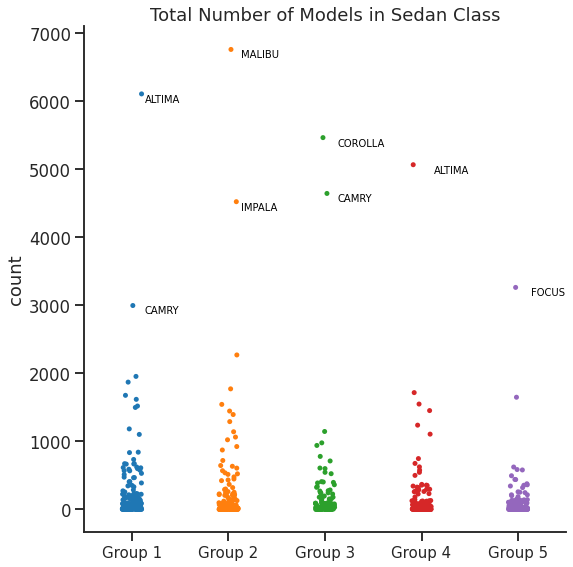

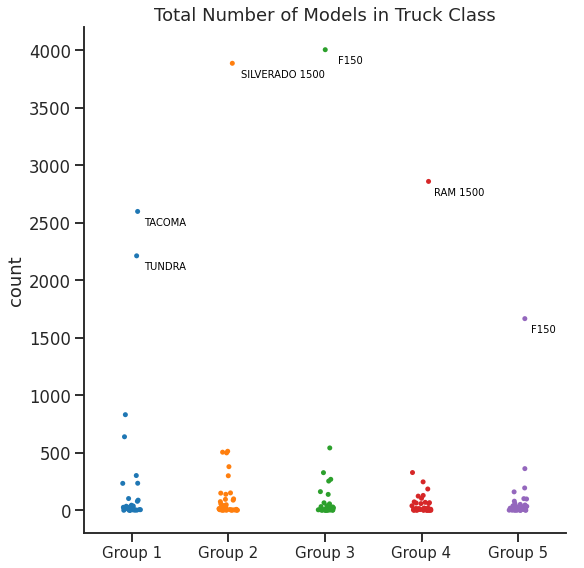

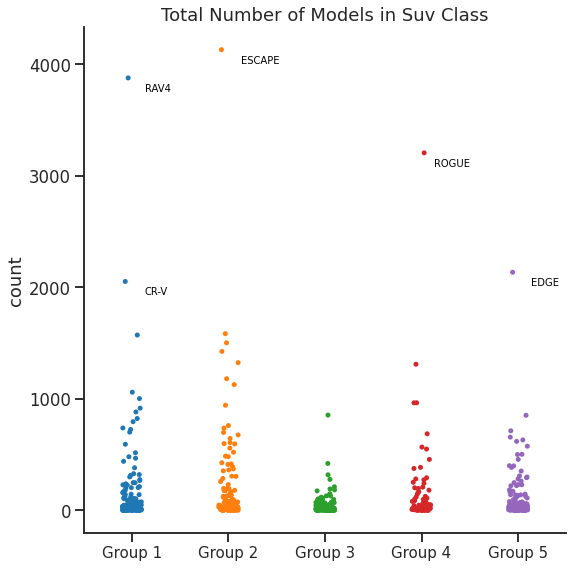

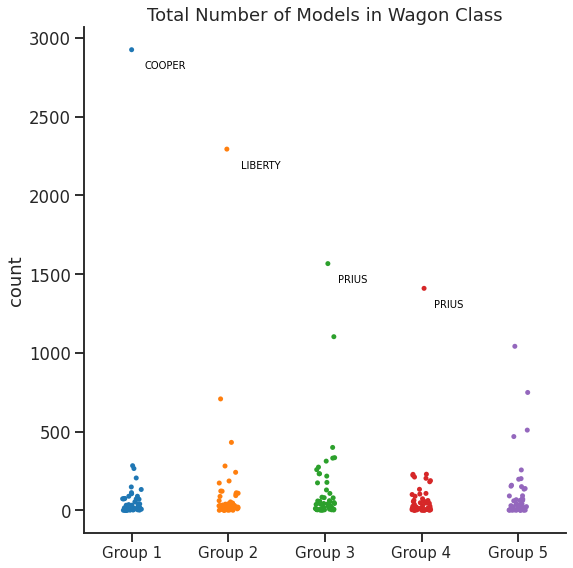

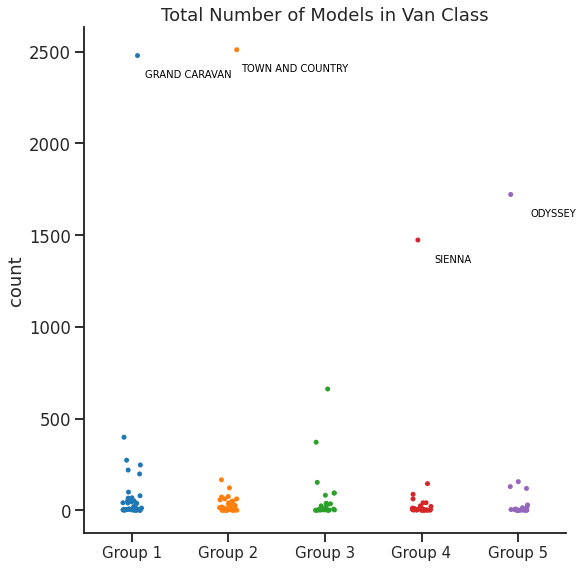

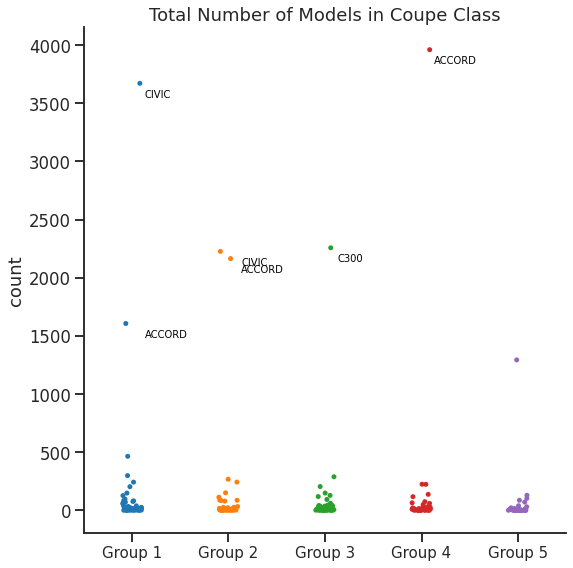

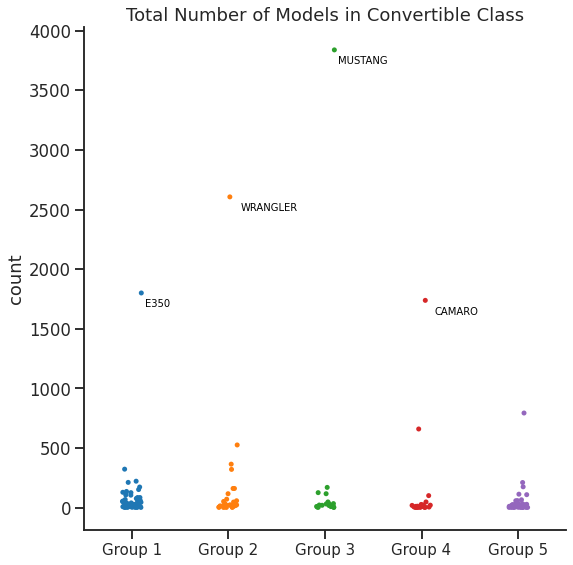

In [12]:
#sns.set_theme(style = "darkgrid")
#sns.set(rc={'axes.facecolor':'white'})

for index, car in enumerate(vehicle_classes):
    data = car.groupby(['purchase_make', 'purchase_model',
                        'cluster_label']).count().sort_values(by = 'cluster_label',ascending = False).reset_index()


    p1 = sns.catplot(x = "cluster_label", y ='trade_in',order = [0,1,2,3,4], data = data,height = 8)
    for x, y, s in zip(data['cluster_label'], data['trade_in'],data['purchase_model']):
        if y > max(data['trade_in'])//2.5:
            if s == 'F150':
                s = s + '       '
            plt.text(x = x + .13, # x-coordinate position of data label
            y = y-120, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = s, # data label, formatted to ignore decimals
            color = 'black',
            fontsize = 10,
            horizontalalignment='left') # set colour of line)

    p1.set(title='Total Number of Models in {0} Class'.format(vehicle_classes_name[index].capitalize() ))
    p1.set_axis_labels("", "count").set_xticklabels(["Group 1", 'Group 2',"Group 3", 
                                                     'Group 4',"Group 5"], fontsize = 15)
    p1.savefig(vehicle_classes_name[index]+"ClusterGroupings", dpi = 600)    
    #, 'Cluster 5',                                        'Cluster 6']

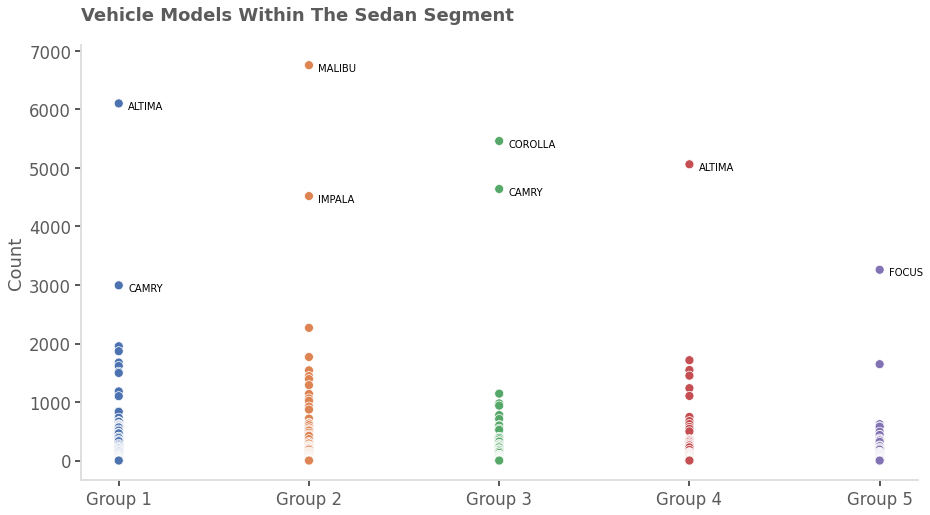

In [147]:
plt.figure(figsize=(15,8))
data = sedan.groupby(['purchase_make', 'purchase_model',
                        'cluster_label']).count().sort_values(by = ['trade_in'],ascending = [False]).reset_index()#.groupby('cluster_label').head(1)
ax = sns.scatterplot(data=data,x='cluster_label',y='trade_in',hue='cluster_label',palette="deep")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.set_xticks(np.arange(0, 5), minor=False)
ax.set_yticks(np.arange(0, 8000,1000), minor=False)
ax.set(xticklabels=['Group 1','Group 2','Group 3','Group 4','Group 5'])


for x, y, s in zip(data['cluster_label'], data['trade_in'],data['purchase_model']):
    if y > max(data['trade_in'])//2.5:
        if s == 'F150':
            s = s + '       '
        plt.text(x = x + .05, # x-coordinate position of data label
        y = y-100, # y-coordinate position of data label, adjusted to be 150 below the data point
        s = s, # data label, formatted to ignore decimals
        color = 'black',
        fontsize = 10,
        horizontalalignment='left') # set colour of line

ax.set_title('Vehicle Models Within The Sedan Segment', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
ax.set_ylabel('Count',color='#5B5B5B')
ax.set_xlabel('',color='#5B5B5B')
ax.get_legend().remove()
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)

In [148]:
for index, vehicle in enumerate(vehicle_classes):
    print("{0} is {1}% of total\n".format(vehicle_classes_name[index], len(vehicle)/len(carmax_df) * 100))

sedan is 42.4560378111354% of total

truck is 8.083478984134834% of total

suv is 25.6748174915841% of total

wagon is 7.755834930340513% of total

van is 3.970506415191894% of total

coupe is 6.892889056239006% of total

convertible is 5.166435311374251% of total



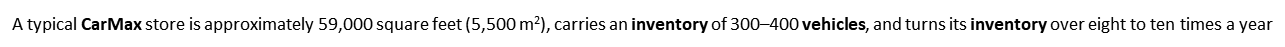

sedan is 170 of 400 vehichles 

truck is 32 of 400 vehichles 

suv is 103 of 400 vehichles 

wagon is 31 of 400 vehichles 

van is 16 of 400 vehichles 

coupe is 28 of 400 vehichles 

convertible is 21 of 400 vehichles 



Text(0, 0.5, 'Count')

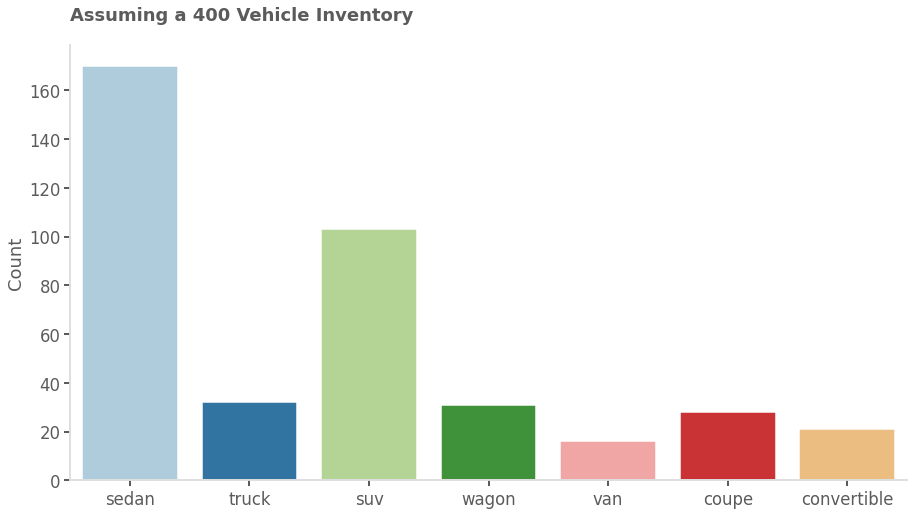

In [233]:
plt.figure(figsize=(15,8))
dicta= {}
total = 0
for index, vehicle in enumerate(vehicle_classes):
    count = round(len(vehicle)/len(carmax_df) * 400)
    dicta[vehicle_classes_name[index]] = count
    total+=count
    print("{0} is {1} of 400 vehichles \n".format(vehicle_classes_name[index],count ))
ax = sns.barplot(x=list(dicta.keys()),y=list(dicta.values()),palette="Paired")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Assuming a 400 Vehicle Inventory', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
ax.set_ylabel('Count',color='#5B5B5B')

In [165]:
Distributions = {'sedan':170, 'truck':32,'suv':102, 'wagon':31, 'van':16, 'coupe':28, 'convertible':21}

Figure out he top 15 in each class

In [32]:
sedan.purchase_model.value_counts()[:10]

ALTIMA     11560
CAMRY       9462
MALIBU      7100
COROLLA     6270
IMPALA      5429
SONATA      5163
FOCUS       4636
SENTRA      4496
FUSION      4492
VERSA       4331
Name: purchase_model, dtype: int64

In [183]:
classDist = {}
for index, vehicle in enumerate(vehicle_classes):
    top10 = vehicle.purchase_model.value_counts()[:10]
    
    temp = {}
    for name, i in enumerate(top10):
        temp[top10.index[name]] = i/len(vehicle)
    
    classDist[vehicle_classes_name[index]] = temp

In [202]:
counts.reset_index()

,index,count
0,ALTIMA,13
1,CAMRY,11
2,MALIBU,8
3,COROLLA,7
4,IMPALA,6
5,SONATA,6
6,FOCUS,5
7,SENTRA,5
8,FUSION,5
9,VERSA,5


In [206]:
counts

,count
ALTIMA,13
CAMRY,11
MALIBU,8
COROLLA,7
IMPALA,6
SONATA,6
FOCUS,5
SENTRA,5
FUSION,5
VERSA,5


Text(0.5, 0, 'Model')

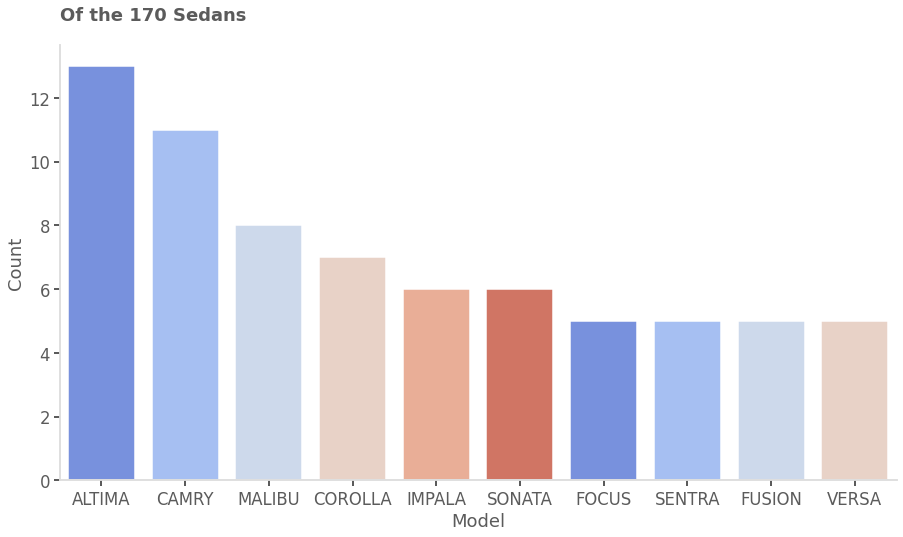

In [225]:
counts = pd.DataFrame.from_dict(classDist['sedan'],orient='index').rename(columns={0:"count"})*170
counts['count'] = counts['count'].apply(round)
counts = counts.reset_index()
plt.figure(figsize=(15,8))
cc = sns.color_palette("Blues", as_cmap=True)
ax = sns.barplot(data=counts,x='index',y='count',palette=sns.color_palette("coolwarm", as_cmap=False))
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Of the 170 Sedans', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
ax.set_ylabel('Count',color='#5B5B5B')
ax.set_xlabel('Model',color='#5B5B5B')

In [35]:
actualNums = {}
for classkey, dictvalue in classDist.items():
    temp = []
    for model,percent in dictvalue.items():
        temp.append((model,round(percent * Distributions[classkey])))
    
    actualNums[classkey] = temp

In [36]:
x = 0
for i in actualNums.values():
    for j in i:
        x += j[1]

x

209

In [37]:
actualNums

{'sedan': [('ALTIMA', 13),
  ('CAMRY', 11),
  ('MALIBU', 8),
  ('COROLLA', 7),
  ('IMPALA', 6),
  ('SONATA', 6),
  ('FOCUS', 5),
  ('SENTRA', 5),
  ('FUSION', 5),
  ('VERSA', 5)],
 'truck': [('F150', 7),
  ('SILVERADO 1500', 4),
  ('RAM 1500', 4),
  ('TACOMA', 3),
  ('TUNDRA', 3),
  ('SIERRA 1500', 2),
  ('RANGER', 1),
  ('FRONTIER', 1),
  ('TITAN', 1),
  ('F250', 1)],
 'suv': [('ESCAPE', 5),
  ('ROGUE', 5),
  ('RAV4', 5),
  ('EDGE', 4),
  ('CR-V', 4),
  ('MURANO', 3),
  ('EQUINOX', 3),
  ('EXPLORER', 2),
  ('GRAND CHEROKEE', 2),
  ('TAHOE', 2)],
 'wagon': [('LIBERTY', 4),
  ('PRIUS', 3),
  ('COOPER', 3),
  ('SOUL', 2),
  ('YARIS', 2),
  ('CALIBER', 2),
  ('CAPTIVA SPORT', 1),
  ('PT CRUISER', 1),
  ('FIT', 1),
  ('500', 1)],
 'van': [('TOWN AND COUNTRY', 3),
  ('GRAND CARAVAN', 3),
  ('ODYSSEY', 3),
  ('SIENNA', 2),
  ('MAZDA5', 1),
  ('ROUTAN', 1),
  ('QUEST', 1),
  ('SEDONA', 0),
  ('E-250', 0),
  ('E-350', 0)],
 'coupe': [('ACCORD', 9),
  ('CIVIC', 7),
  ('C300', 4),
  ('TC', 1),
 

In [38]:
classDist

{'sedan': {'ALTIMA': 0.07651068899331524,
  'CAMRY': 0.06262492554106824,
  'MALIBU': 0.046991859156793964,
  'COROLLA': 0.04149844463564763,
  'IMPALA': 0.03593222582566682,
  'SONATA': 0.034171685750215106,
  'FOCUS': 0.03068369845787279,
  'SENTRA': 0.029757098418161362,
  'FUSION': 0.02973062413131246,
  'VERSA': 0.028665034085644317},
 'truck': {'F150': 0.2062780269058296,
  'SILVERADO 1500': 0.13734487433517573,
  'RAM 1500': 0.13685820558278583,
  'TACOMA': 0.09211944241665798,
  'TUNDRA': 0.08318559460492926,
  'SIERRA 1500': 0.04699829665936663,
  'RANGER': 0.046581152014461016,
  'FRONTIER': 0.046372579692008205,
  'TITAN': 0.03208537560399068,
  'F250': 0.027114401918865366},
 'suv': {'ESCAPE': 0.05303710189340046,
  'ROGUE': 0.045715223815256646,
  'RAV4': 0.04460982817117216,
  'EDGE': 0.04117325161431542,
  'CR-V': 0.03806501039728576,
  'MURANO': 0.026026047936959614,
  'EQUINOX': 0.024734595600306445,
  'EXPLORER': 0.02441720477180694,
  'GRAND CHEROKEE': 0.023071029878

In [39]:
profile = ProfileReport(sedan[sedan.cluster_label == 1], title='Pandas Profiling Report', explorative=False)

In [50]:
carmax_df.groupby(['subsequent_purchases','purchase_model']).count().sort_values(by ='purchase_make', ascending = False).to_csv('lol.csv')

In [41]:
profile.to_file("your_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
ProfileReport(actualNums)

AttributeError: 'dict' object has no attribute 'index'

In [ ]:
cluster_df.subsequent_purchases.value_counts()

In [ ]:
sedan.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0]).to_html('test.html')

1; 
ALTIMA
CAMRY
ACCORD
MALIBU
F150
COROLLA



2: 
ALTIMA
CAMRY
ACCORD
CIVIC
MALIBU
F150



3 - Altima
Accord
Camry 
f150
Corolla 
Malibu
Civic